# **Capsule Network for MNIST**

## **1. Libraries**

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

## **2. Explore example Dataset**

In [ ]:
# import MNIST dataset in pytorch
train_data = torchvision.datasets.MNIST(root='./Data', download=True, train=True)
test_data = torchvision.datasets.MNIST(root='./Data', download=True, train=False)

In [ ]:
# print size of train and test data
print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  60000
Length of test data:  10000


size: (28, 28) - label: 1


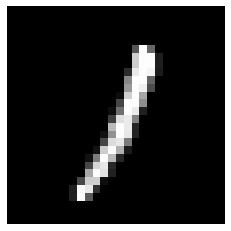

In [ ]:
# print size and label of 100th image
image_99, label_99 = train_data[99]
print("size: {} - label: {}".format(image_99.size, label_99))
image_99 = image_99.convert('RGB')
plt.imshow(image_99)
plt.axis('off')
plt.show()

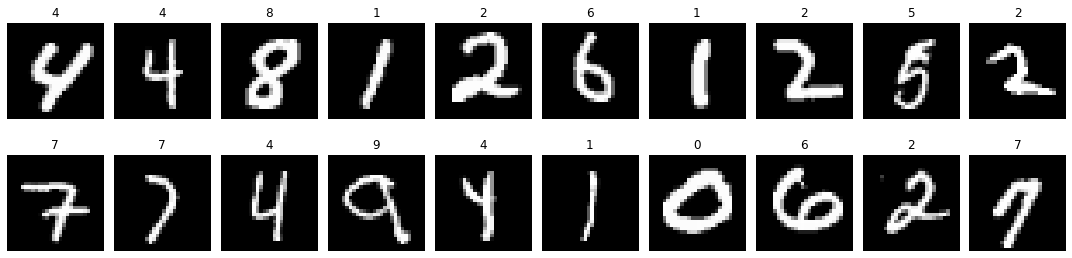

In [ ]:
# visualize 20 random train data images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))

for i in range(2):
    for j in range(10):
        index = random.randint(0, 60000)
        image, label = train_data[index]
        image = image.convert('RGB')
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"{label}")
        axes[i, j].axis('off')
        
plt.tight_layout()
plt.show()

## **3. Dataloader**

In [ ]:
class MNISTDataLoader:
    def __init__(self, batch_size=128,
                       valid_size=0.2,
                       shuffle=True,
                       train=True):
        self.batch_size = batch_size
        self.valid_size = valid_size
        self.shuffle = shuffle
        self.train = train

    def load_data(self):
        # transform
        mean = [0.1307] # normalize 1D
        std = [0.3081]

        # training transform|
        train_transform = transforms.Compose([
            # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
            transforms.ToTensor()
            # transforms.Normalize(mean, std)
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor()
            # transforms.Normalize(mean, std)
        ])

        # create dataset
        train_data = torchvision.datasets.MNIST(root='./Data', download=True, train=True, transform=train_transform)
        test_data = torchvision.datasets.MNIST(root='./Data', download=True, train=False, transform=test_transform)

        # create dataloader
        train_loader = DataLoader(
            dataset=train_data, batch_size=self.batch_size, shuffle=self.shuffle
        )

        test_loader = DataLoader(
            dataset=test_data, batch_size=self.batch_size, shuffle=False
        )
        return (train_loader, test_loader)

## **4. Model: CapsNet**

### **4.1. Capsule layer**

In [ ]:
class DigitCapsLayer(nn.Module):
    def __init__(self, n_caps=10, n_dims=16, n_routing_iterations=3, device=None):
        super(DigitCapsLayer, self).__init__()

        self.device = device

        self.n_caps = n_caps
        self.n_dims = n_dims
        self.n_routing_iterations = n_routing_iterations

        # init weight matrix W
        self.routing_weights = nn.Parameter(torch.randn(1, 32*6*6, n_caps, n_dims, 8))


    def squash(self, tensor=None, dim=-1, epsilon=1e-7):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        safe_norm = torch.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = tensor / safe_norm
        return squash_factor * unit_vector


    def forward(self, x):
        # x: [Batch_size, 1152, 8]

        # create W and x
        batch_size = x.size(dim=0)

        W = self.routing_weights.repeat(batch_size, 1, 1, 1, 1) # [BS, 1152, 10, 16, 8]
        
        x = torch.unsqueeze(x, dim=-1)
        x = torch.unsqueeze(x, dim=2)
        x = x.repeat(1, 1, 10, 1, 1) # [BS, 1152, 10, 8, 1]

        # Compute the Predicted Output Vectors (u_hat[j|i])
        prediction_vectors = W @ x # [BS, 1152, 10, 16, 1]
        

        # Routing by agreement
       
        # Initial logits b[i, j]
        initial_logits = Variable(torch.zeros(batch_size, 32*6*6, self.n_caps, 1, 1)).to(self.device) # [BS, 1152, 10, 1, 1]
        
        for i in range(self.n_routing_iterations):
            # The coupling coefficients c[i] = softmax(b[i])
            coupling_coefs = F.softmax(initial_logits, dim=2)
            
            outputs = (coupling_coefs * prediction_vectors).sum(dim=1, keepdims=True) # [BS, 1, 10, 16, 1]
            outputs = self.squash(tensor=outputs, dim=-2)

            if i != self.n_routing_iterations - 1:
                outputs = outputs.repeat(1, 32*6*6, 1, 1, 1)
                agreement = torch.transpose(prediction_vectors, -2, -1) @ outputs # [BS, 1152, 10, 1, 1]
                initial_logits += agreement 
        
        return outputs

### **4.2. Capsule Network**

In [ ]:
class CapsNet(nn.Module):
    def __init__(self, n_routing_iterations=3, device=None):
        super(CapsNet, self).__init__()

        self.device = device

        # Layer 1: Convolution
        self.Conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1, padding=0)

        # Layer 2: Primary Capsules
        self.Conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=9, stride=2, padding=0)

        # Layer 3: Digit Capsules
        self.digitcaps = DigitCapsLayer(n_routing_iterations=n_routing_iterations, device=device)

        # Reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(16*10, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid()
        )

    def squash(self, tensor=None, dim=-1, epsilon=1e-7):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        safe_norm = torch.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = tensor / safe_norm
        return squash_factor * unit_vector


    def safe_norm(self, tensor=None, dim=-1, epsilon=1e-7, keep_dims=False):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=keep_dims)
        return torch.sqrt(squared_norm + epsilon)


    def forward(self, x, y=None):
        # 1st layer
        x = self.Conv1(x)
        x = F.relu(x, inplace=True)

        # primary capsules
        x = self.Conv2(x)
        x = F.relu(x, inplace=True)
        x = torch.reshape(x, (-1, 32*6*6, 8))
        x = self.squash(tensor=x)
        
        # digit capsules
        caps_2_output = self.digitcaps(x) # [BS, 1, 10, 16, 1]

        # reconstruction

        # find longest vector
        y_proba = self.safe_norm(caps_2_output, dim=-2)
        y_proba_argmax = torch.argmax(y_proba, dim=2)
        y_pred = torch.squeeze(y_proba_argmax, dim=2)
        y_pred = torch.squeeze(y_pred, dim=1)
        
        mask = None
        if y is None:
            mask = torch.eye(10).to(self.device).index_select(dim=0, index=y_pred)
        else:
            mask = torch.eye(10).to(self.device).index_select(dim=0, index=y)
        

        reconstruction_mask_reshaped = torch.reshape(mask, [-1, 1, 10, 1, 1])
        
        caps2_output_masked = torch.multiply(caps_2_output, reconstruction_mask_reshaped)

        decoder_input = torch.reshape(caps2_output_masked, [-1, 10 * 16])

        reconstructions = self.decoder(decoder_input)

        return caps_2_output, y_pred, reconstructions

## **5. Loss Function**

In [ ]:
class CapsuleLoss(nn.Module):
    def __init__(self, m_plus=0.9, m_minus=0.1, lambda_=0.5, device=None):
        super(CapsuleLoss, self).__init__()

        self.device = device

        # self.reconstruction_loss = nn.MSELoss(reduction='sum')

        # Hyperparameters for loss function
        self.m_plus = m_plus
        self.m_minus = m_minus
        self.lambda_ = lambda_


    def safe_norm(self, tensor=None, dim=-1, epsilon=1e-7, keep_dims=False):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=keep_dims)
        return torch.sqrt(squared_norm + epsilon)


    def forward(self, images, labels, caps_2_output, reconstructions):
        
        caps2_output_norm = self.safe_norm(caps_2_output, dim=-2, keep_dims=True) # [BS, 1, 10, 1, 1]

        zero = torch.zeros(caps2_output_norm.size()).to(self.device) # [BS, 1, 10, 1, 1]

        present_error_raw = torch.square((torch.maximum(zero, self.m_plus - caps2_output_norm)))
        present_error = torch.reshape(present_error_raw, shape=(-1, 10)) # [BS, 10]

        absent_error_raw = torch.square((torch.max(zero, caps2_output_norm - self.m_minus)))
        absent_error = torch.reshape(absent_error_raw, shape=(-1, 10)) # [BS, 10]

        margin_loss = labels * present_error + self.lambda_ * (1. - labels) * absent_error # [BS, 10]
        margin_loss = torch.sum(margin_loss, dim=-1, keepdim=True)
        margin_loss = torch.mean(margin_loss)
        

        images = images.view(reconstructions.size()[0], -1)
        
        # reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        images_flat = torch.reshape(images, [-1, 28*28])
        squared_difference = torch.square(images_flat - reconstructions)
        reconstruction_loss = torch.sum(squared_difference, dim=-1, keepdim=True)
        reconstruction_loss = torch.mean(reconstruction_loss)
        
        final_loss = margin_loss + 0.0005 * reconstruction_loss

        return margin_loss, reconstruction_loss, final_loss

## **6. Training**

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# model
model = CapsNet(n_routing_iterations=3, device=device)
model.to(device)

CapsNet(
  (Conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (Conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (digitcaps): DigitCapsLayer()
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
# Hyperparameters
num_epochs = 100
batch_size = 128
learning_rate = 0.0003
weight_decay = 0.0001

In [ ]:
# loss and optimizer
criterion = CapsuleLoss(device=device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.Adam([
    {'params': model.Conv1.parameters()},
    {'params': model.Conv2.parameters()},
    {'params': model.digitcaps.parameters()},
    {'params': model.decoder.parameters(), 'weight_decay': 0, 'lr': 0.001}
], lr=learning_rate, weight_decay=weight_decay)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.01)

In [ ]:
def train_phase(train_loader, model, criterion, optimizer):
    n_iterations = len(train_loader)
    size = 0
    train_final_loss = 0
    train_margin_loss = 0
    train_reconstruction_loss = 0
    train_accuracy = 0
    for images, labels in tqdm(train_loader, total=n_iterations):
        
        images = images.to(device)
        labels = labels.to(device)
      
        size += labels.size(0)

        # forward pass
        caps_2_outputs, y_pred, reconstructions = model(x=images, y=labels)
        
        labels_one_hot = torch.eye(10).to(device).index_select(dim=0, index=labels) # [BS, 10]
        
        margin_loss, reconstruction_loss, final_loss = criterion(images, labels_one_hot, caps_2_outputs, reconstructions)

        train_final_loss += final_loss.item()
        train_margin_loss += margin_loss.item()
        train_reconstruction_loss += reconstruction_loss.item()
        
        train_accuracy += (y_pred == labels).sum().item()

        # backpropagation and optimization
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        
        del images, labels, labels_one_hot, caps_2_outputs, y_pred, reconstructions
        
    train_final_loss /= n_iterations
    train_margin_loss /= n_iterations
    train_reconstruction_loss /= n_iterations
    train_accuracy /= size
    return train_final_loss, train_margin_loss, train_reconstruction_loss, train_accuracy * 100

In [ ]:
def test_phase(test_loader, model, criterion):
    test_final_loss = 0
    test_margin_loss = 0
    test_reconstruction_loss = 0
    test_accuracy = 0
    n_iterations = len(test_loader)
    size = 0
    with torch.no_grad():
        # turn off model.train() -> turn on model.eval() -> turn off model.eval() -> and then auto turn on model.train() again
        for images, labels in tqdm(test_loader, total=n_iterations):
            images = images.to(device)
            labels = labels.to(device)

            size += labels.size(0)

            caps_2_outputs, y_pred, reconstructions = model(x=images)
        
            labels_one_hot = torch.eye(10).to(device).index_select(dim=0, index=labels)
            
            margin_loss, reconstruction_loss, final_loss = criterion(images, labels_one_hot, caps_2_outputs, reconstructions)

            test_final_loss += final_loss.item()
            test_margin_loss += margin_loss.item()
            test_reconstruction_loss += reconstruction_loss.item()
            
            test_accuracy += (y_pred == labels).sum().item()
            del images, labels, labels_one_hot, caps_2_outputs, y_pred, reconstructions

    test_final_loss /= n_iterations
    test_margin_loss /= n_iterations
    test_reconstruction_loss /= n_iterations
    test_accuracy /= size
    return test_final_loss, test_margin_loss, test_reconstruction_loss, test_accuracy * 100 

In [ ]:
# Training + Validation
dataloader = MNISTDataLoader(batch_size=batch_size)
train_loader, test_loader = dataloader.load_data()

loss_opt = 1e9
acc_opt = -1e9

history_train_final_loss = []
history_test_final_loss = []
history_train_margin_loss = []
history_test_margin_loss = []
history_train_reconstruction_loss = []
history_test_reconstruction_loss = []
history_train_acc = []
history_test_acc = []

for epoch in range(num_epochs):
    print()
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    
    
    train_final_loss, train_margin_loss, train_reconstruction_loss, train_accuracy = train_phase(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer)
    print('Train Loss: {:.4f}, Train Margin Loss: {:.4f}, Train Reconstruction Loss: {:.4f}, Train Accuracy: {:.4f}%' .format(train_final_loss, train_margin_loss, train_reconstruction_loss, train_accuracy))

    test_final_loss, test_margin_loss, test_reconstruction_loss, test_accuracy = test_phase(test_loader=test_loader, model=model, criterion=criterion)
    print('Valid Loss: {:.4f}, Valid Margin Loss: {:.4f}, Valid Reconstruction Loss: {:.4f}, Valid Accuracy: {:.4f}%' .format(test_final_loss, test_margin_loss, test_reconstruction_loss, test_accuracy))

    # scheduler.step()

    history_train_final_loss.append(train_final_loss)
    history_test_final_loss.append(test_final_loss)
    history_train_margin_loss.append(train_margin_loss)
    history_test_margin_loss.append(test_margin_loss)
    history_train_reconstruction_loss.append(train_reconstruction_loss)
    history_test_reconstruction_loss.append(test_reconstruction_loss)
    history_train_acc.append(train_accuracy)
    history_test_acc.append(test_accuracy)
    
    if test_final_loss < loss_opt and test_accuracy >= acc_opt:
        loss_opt = test_final_loss
        acc_opt = test_accuracy
        torch.save(model.state_dict(), 'best_v3.pt')
    torch.save(model.state_dict(), 'last_v3.pt')

In [ ]:
print("Optimal loss: ", loss_opt)
print("Accuracy loss: ", acc_opt)

Optimal loss:  0.015144154175974523
Accuracy loss:  99.3


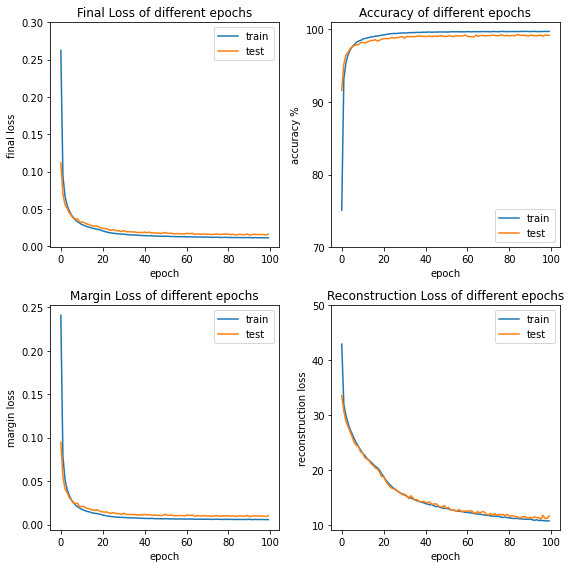

In [ ]:
import seaborn as sn

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

sn.lineplot(ax=axes[0, 0], data=history_train_final_loss)
sn.lineplot(ax=axes[0, 0], data=history_test_final_loss)
axes[0, 0].set_title("Final Loss of different epochs")
axes[0, 0].set_xlabel("epoch")
axes[0, 0].set_ylabel("final loss")

sn.lineplot(ax=axes[0, 1], data=history_train_acc)
sn.lineplot(ax=axes[0, 1], data=history_test_acc)
axes[0, 1].set_title("Accuracy of different epochs")
axes[0, 1].set_xlabel("epoch")
axes[0, 1].set_ylabel("accuracy %")

sn.lineplot(ax=axes[1, 0], data=history_train_margin_loss)
sn.lineplot(ax=axes[1, 0], data=history_test_margin_loss)
axes[1, 0].set_title("Margin Loss of different epochs")
axes[1, 0].set_xlabel("epoch")
axes[1, 0].set_ylabel("margin loss")

sn.lineplot(ax=axes[1, 1], data=history_train_reconstruction_loss)
sn.lineplot(ax=axes[1, 1], data=history_test_reconstruction_loss)
axes[1, 1].set_title("Reconstruction Loss of different epochs")
axes[1, 1].set_xlabel("epoch")
axes[1, 1].set_ylabel("reconstruction loss")


labels = ['train', 'test']
axes[0, 0].legend(labels)
axes[0, 1].legend(labels)
axes[1, 0].legend(labels)
axes[1, 1].legend(labels)
axes[0, 0].set_xticks(range(0, 101, 20))
axes[0, 1].set_xticks(range(0, 101, 20))
axes[0, 0].set_yticks(np.arange(0., 0.35, 0.05))
axes[0, 1].set_yticks(range(70, 101, 10))
axes[1, 1].set_yticks(range(10, 51, 10))


plt.tight_layout()
plt.savefig('result.jpg')
plt.show()

## **7. Inference**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
infer_model = CapsNet(n_routing_iterations=3, device=device)
infer_model.load_state_dict(torch.load('best_v3.pt'))
infer_model.to(device)

CapsNet(
  (Conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (Conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (digitcaps): DigitCapsLayer()
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
test_data = torchvision.datasets.MNIST(root='./test_data', download=True, train=False)
len(test_data)

10000

In [ ]:
# test transform
# mean = [0.1307] # normalize 1D
# std = [0.3081]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

ground_truth_images = []
ground_truth_labels = []

test_images = []
test_labels = []

K = 20
i = 0
while i < K:
    index = random.randint(0, len(test_data))
    image, label = test_data[index]
    ground_truth_images.append(image)
    ground_truth_labels.append(label)
    image_tensor = test_transform(image)
    test_images.append(image_tensor)
    test_labels.append(label)
    i += 1
print("Length of images: ", len(test_images))
print("Length of labels: ", len(test_labels))

Length of images:  20
Length of labels:  20


In [ ]:
infer_data = torch.stack(test_images)
infer_data.size()

torch.Size([20, 1, 28, 28])

In [ ]:
infer_data = infer_data.to(device)

In [ ]:
infer_caps_2_outputs, infer_y_pred, infer_reconstructions = infer_model(infer_data)

In [ ]:
ground_truth_labels

[1, 8, 8, 7, 8, 7, 4, 9, 5, 9, 7, 4, 1, 1, 5, 8, 8, 1, 2, 0]

In [ ]:
infer_y_pred

tensor([1, 8, 8, 7, 8, 7, 4, 9, 5, 9, 7, 4, 1, 1, 5, 8, 8, 1, 2, 0],
       device='cuda:0')

In [ ]:
infer_reconstructions.size()

torch.Size([20, 784])

In [ ]:
infer_images = torch.reshape(infer_reconstructions, [-1, 28, 28])
infer_images.size()

torch.Size([20, 28, 28])

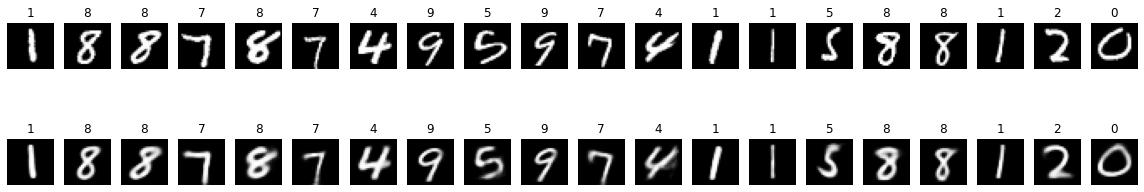

In [ ]:
fig, axes = plt.subplots(2, 20, figsize=(16, 4))

for i in range(2):
    for j in range(20):
        if i == 0:
            img = ground_truth_images[j]
            lab = ground_truth_labels[j]
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{lab}")
            axes[i, j].axis('off')
        else:
            img = infer_images[j].cpu().detach().numpy()
            img *= 255
            lab = infer_y_pred[j]
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{lab}")
            axes[i, j].axis('off')
plt.tight_layout()
plt.show()